In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

from utils.visualize import *
from utils.FIR_filter import *
from utils.signal_process import *
from utils.preprocess import *
from utils.model import *
import utils.vision_transformer as VT

import torch
from torch.utils.data import Dataset, DataLoader

import pickle

## Step-by-Step Data Preprocessing Demo

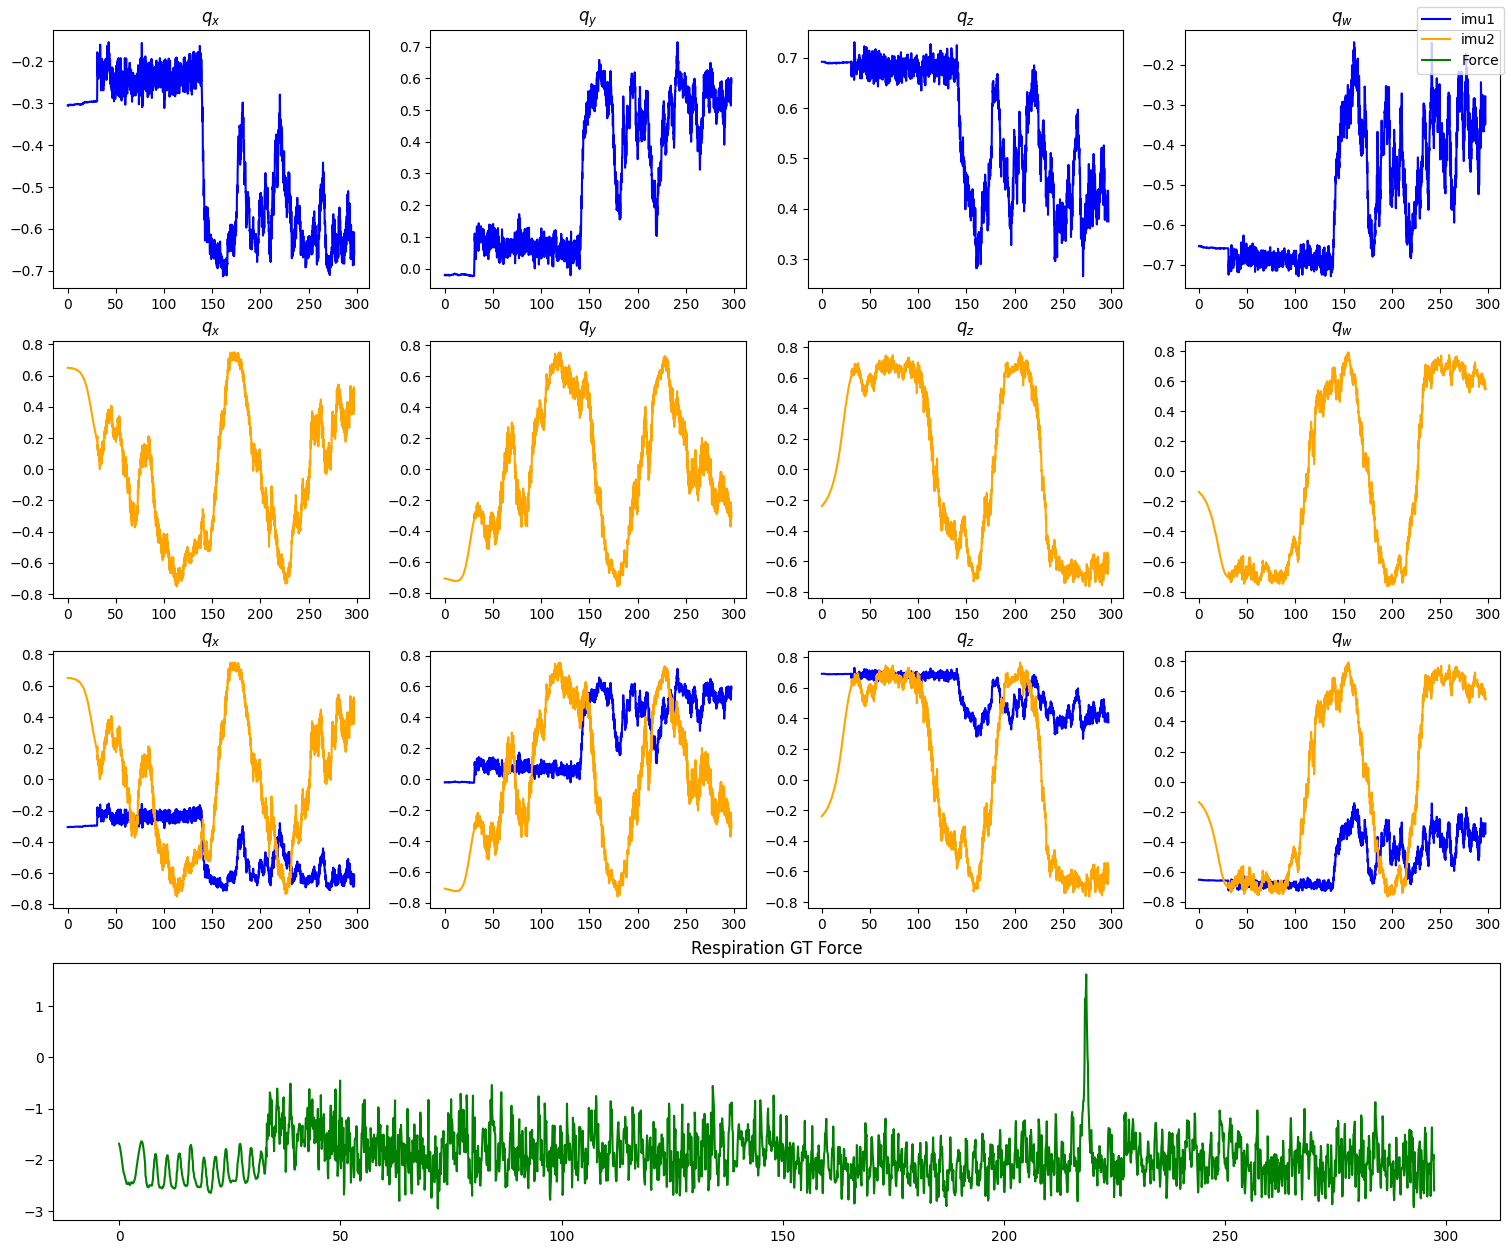

In [5]:
fs = 10
start_pt, end_pt = 0, -1
still_pt = 300 # 500

# file_path = "./data/8P/test/walk_0514_1043.csv"

# walk_0516_0644, *walk_0516_0650, *walk_0516_0701, walk_0516_0707, walk_0516_0713
# **run_0516_0735, *run_0516_0741, run_0516_0752, *run_0516_0807, run_0516_0812
action_name = "run_0516_0735"
file_path = f'./data/5_16/kiri/{action_name}.csv'

data = pd.read_csv(file_path)
data.columns = [
    "Timestamp",
    "imu1_q_x",
    "imu1_q_y",
    "imu1_q_z",
    "imu1_q_w",
    "imu2_q_x",
    "imu2_q_y",
    "imu2_q_z",
    "imu2_q_w",
    "Force",
    "RR",
]
sensor_names=['imu1','imu2']
cols = ['q_x', 'q_y', 'q_z', 'q_w']
data = data.iloc[start_pt:end_pt]

data = align_delay(data, delay=10)
data["Timestamp"] = pd.to_datetime(data["Timestamp"])
data = data.set_index("Timestamp")

draw_imu_curve(data, overlap=True, show_gt=True)
# draw_imu_curve(data, overlap=True, show_gt=False)

best_score/total: 133/300


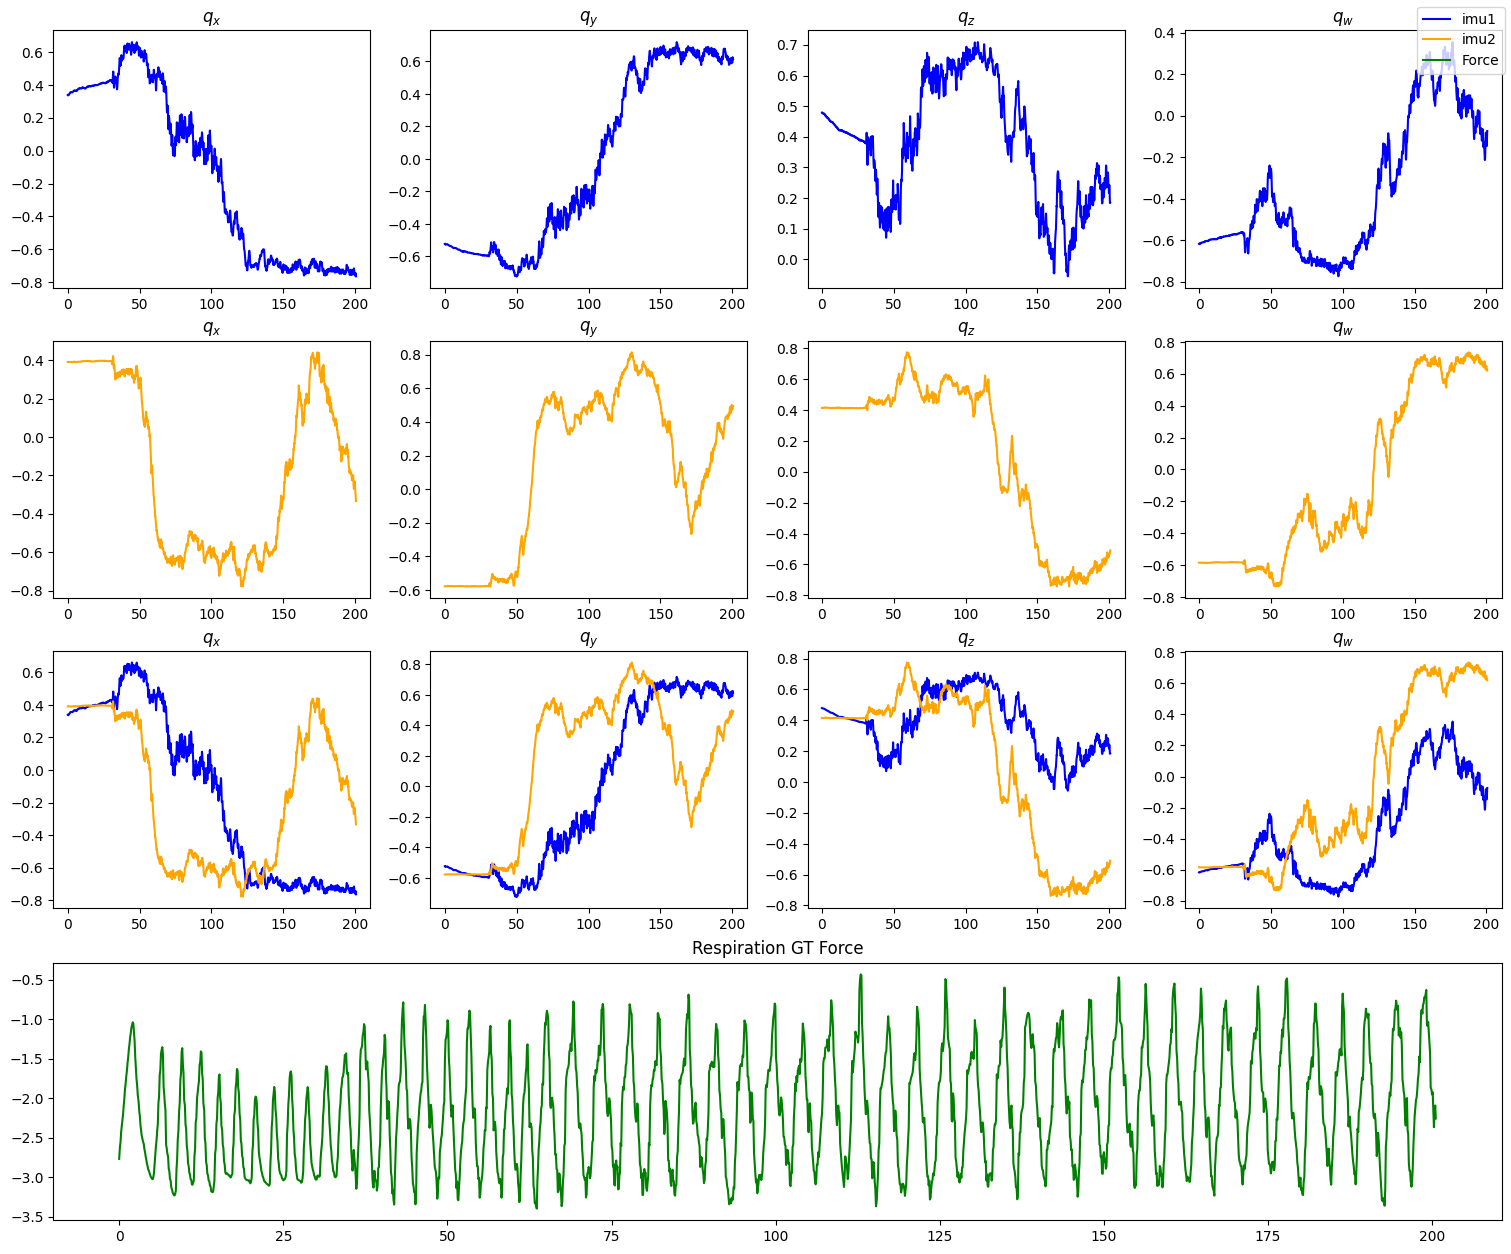

In [29]:
# Align IMUs (IMU2 -> IMU1)
q_corr = Q_RANSAC(data[0:still_pt], pool=1.0, d=0.05)

target, skew = 'imu1', 'imu2'
Q_skew = data[[skew + '_q_x', skew + '_q_y', skew + '_q_z', skew + '_q_w']].to_numpy()
Q_aligned = align_quaternion(q_corr, Q_skew) # (sample num, 4)
data_aligned = data.copy()

for i, col in enumerate(cols):
    data_aligned[[skew + '_' + col]] = Q_aligned[:, i].reshape(-1, 1)

draw_imu_curve(data_aligned, overlap=True, show_gt=True)

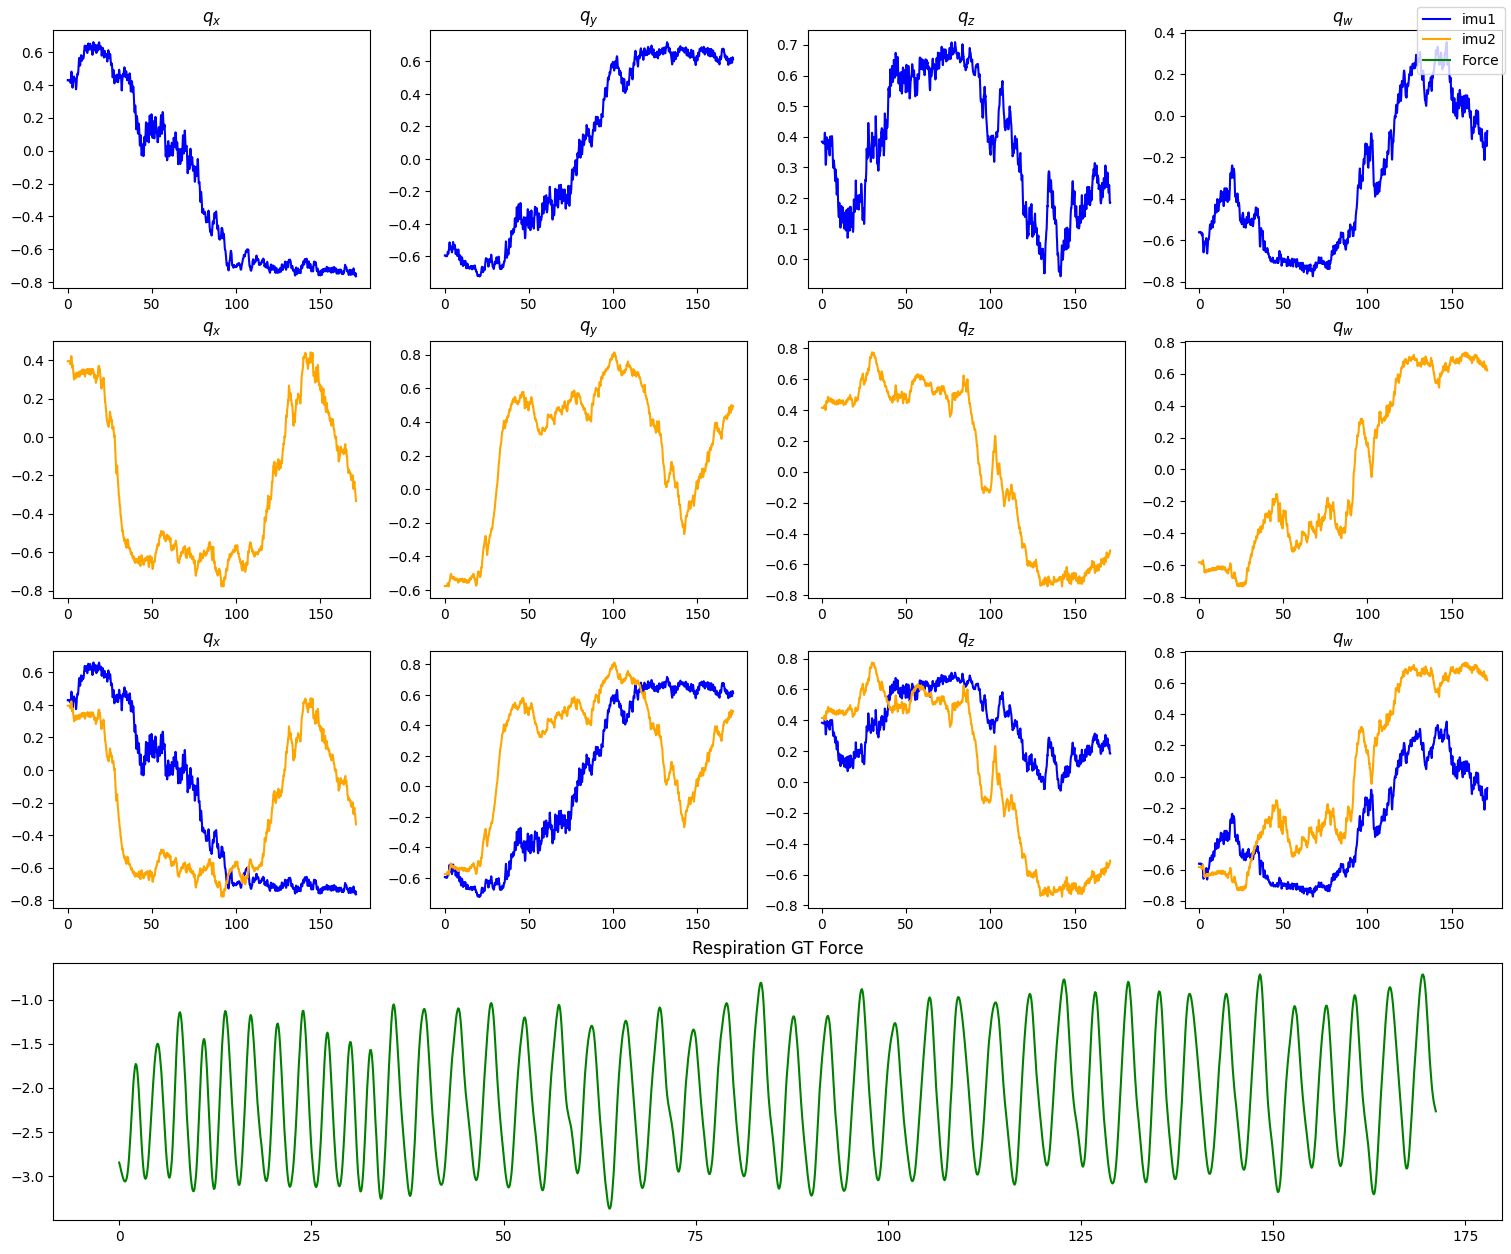

In [27]:
# Handle gt force
data_sp = data_aligned # data used in compute spectrogram shape
data_sp = data_sp[still_pt+0:]
cols = ['q_x', 'q_y', 'q_z', 'q_w'] # for quaternion

data_sp.loc[:, "Force"] = butter_filter(data_sp["Force"], cutoff=0.66)
draw_imu_curve(data_sp, overlap=True, show_gt=True)

## Compute Model Parameters (Spectrogram Shape)

In [5]:
# 1-D spectrogram
# window_size=128
# stride=64
# nperseg=128
# noverlap=64
# out1=True

# 2-D spectrogram
window_size=256
stride=64
nperseg=128
noverlap=64
out1=True
byCol=True

spectrograms_file, gts_file, times_file = prepare_file(file_path, window_size=window_size, stride=stride, nperseg=nperseg, noverlap=noverlap, out_1=out1, byCol=byCol)
dataset_file= IMUSpectrogramDataset(spectrograms_file, gts_file)
file_loader = DataLoader(dataset_file, batch_size=1, shuffle=False)

num_channels = spectrograms_file.shape[1]
num_freq_bins = spectrograms_file.shape[2]  # From computed spectrogram
num_time_steps = spectrograms_file.shape[3]  # From computed spectrogram

best_score/total: 133/300
----------------------------
sepctrograms:(24, 16, 65, 3)
gt:(24, 1)
times:(24, 1)


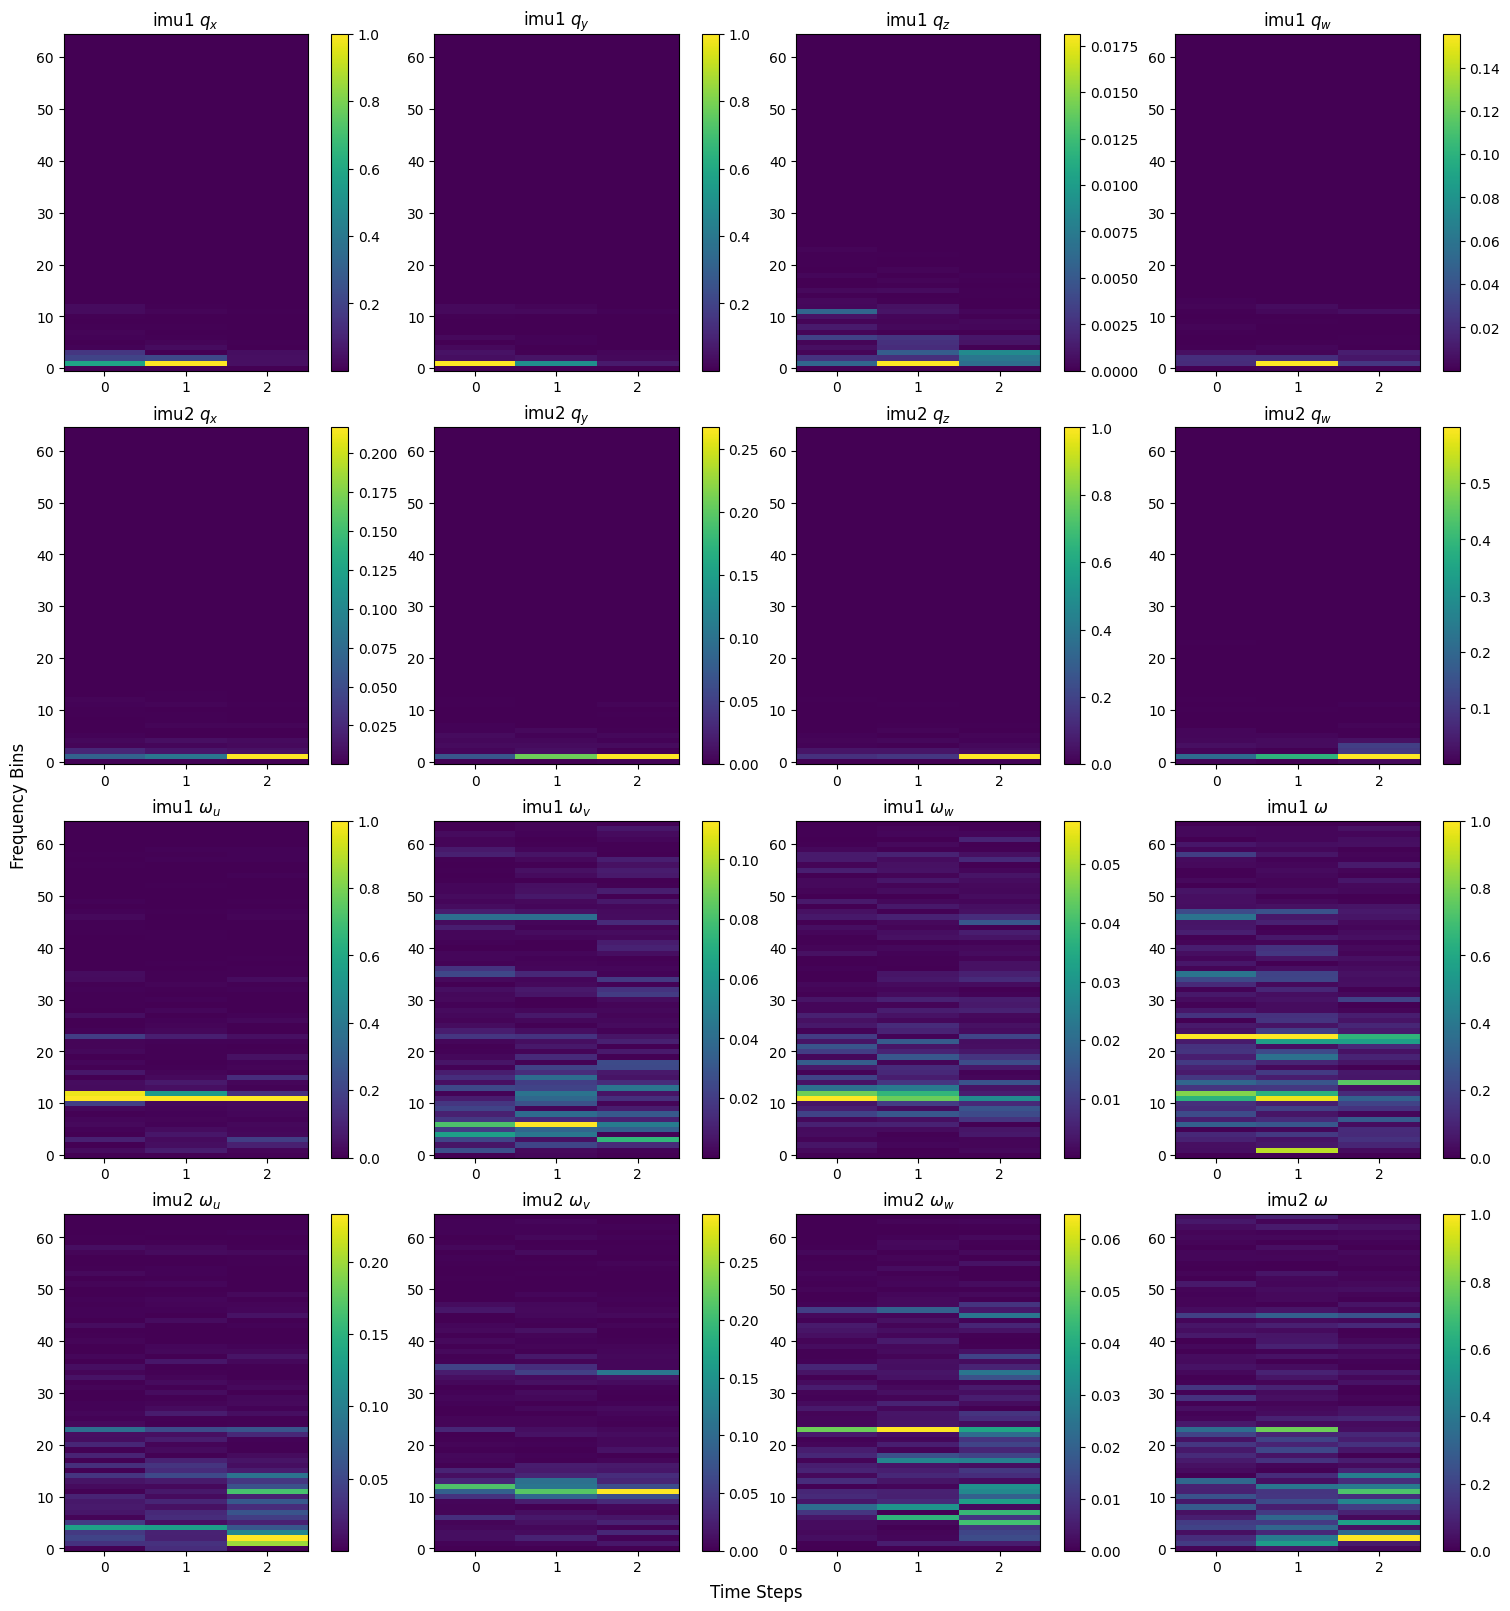

In [6]:
# show one spectrogram
plot_spectrogram_16(spectrograms_file[11])

In [7]:
torch.cuda.is_available()

True

## Testing Model

In [8]:
# Load dataset
dataset_dir = "dataset/"
dataset_name = "8P_16_2D_BC"
pkl_test = pickle.load(open(os.path.join(dataset_dir, f'{dataset_name}_test.pkl'), 'rb'))
input_test, gt_test = pkl_test['input'], pkl_test['gt']

print('Testing data......')
print(f'Testing shape: {input_test.shape}')

num_channels = input_test.shape[1]
num_freq_bins = input_test.shape[2]
num_time_steps = input_test.shape[3]

dataset_test = IMUSpectrogramDataset(input_test, gt_test)
test_loader = DataLoader(dataset_test, batch_size=1, shuffle=True)

Testing data......
Testing shape: (339, 16, 65, 3)


In [9]:
# Test one file
action_name = "walk_0520_0901" # sit_0514_1030, walk_0514_1043, walk_0520_0730, *walk_0520_0901, walk_0520_1031
path_file = f'./data/8P/test/{action_name}.csv'

# spectrograms_file, gts_file, times_file = prepare_file(path_file, window_size=window_size, stride=stride, nperseg=nperseg, noverlap=noverlap)
spectrograms_file, gts_file, times_file = prepare_file(path_file, window_size=window_size, stride=stride, nperseg=nperseg, noverlap=noverlap, out_1=True)
dataset_file= IMUSpectrogramDataset(spectrograms_file, gts_file)
file_loader = DataLoader(dataset_file, batch_size=1, shuffle=False)

best_score/total: 300/300
----------------------------
sepctrograms:(23, 16, 65, 3)
gt:(23, 1)
times:(23, 1)


In [10]:
# Load models
# 2-D spectrogram
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models_name = ['MLP_8P_2D_BC', 'CNN_8P_2D_BC', 'BiLSTM_8P_2D_BC', 'GRU_8P_2D_BC', 'VT_8P_BC_emht2'] # VT_8P_2D_BC
models = [MLP_out1(num_freq_bins, num_time_steps, num_channels=num_channels),
          CNN_out1_2(num_channels=num_channels),
          BiLSTM(num_freq_bins, num_time_steps, num_channels=num_channels),
          GRU(num_freq_bins, num_time_steps, num_channels=num_channels),
          VT.ViTRegression(in_channels=num_channels, patch_size=(3, 3), emb_dim=256, mlp_dim=512, num_heads=8, device=device)]

for i in range(len(models_name)):
    models[i].load_state_dict(torch.load(f'./models/{str(models_name[i])}.pt'))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Evaluate model in whole testing set
    mse, mae = evaluate_model(models[i], test_loader, model_name=models_name[i], device=device)

MLP_8P_2D_BC Evaluation Results - MSE Loss: 0.0046, L1 Loss: 2.9110 1/min
CNN_8P_2D_BC Evaluation Results - MSE Loss: 0.0038, L1 Loss: 3.0284 1/min
BiLSTM_8P_2D_BC Evaluation Results - MSE Loss: 0.0040, L1 Loss: 2.6602 1/min
GRU_8P_2D_BC Evaluation Results - MSE Loss: 0.0051, L1 Loss: 2.7922 1/min
VT_8P_BC_emht2 Evaluation Results - MSE Loss: 0.0028, L1 Loss: 2.6216 1/min


MLP_2D Evaluation Results - MSE Loss: 0.0073, L1 Loss: 4.6972 1/min, R²:-0.5181
CNN_2D Evaluation Results - MSE Loss: 0.0124, L1 Loss: 6.4637 1/min, R²:-1.5713
BiLSTM_2D Evaluation Results - MSE Loss: 0.0076, L1 Loss: 4.6561 1/min, R²:-0.5745
GRU_2D Evaluation Results - MSE Loss: 0.0134, L1 Loss: 5.6506 1/min, R²:-1.7910
ViT_2D Evaluation Results - MSE Loss: 0.0053, L1 Loss: 3.7229 1/min, R²:-0.0987


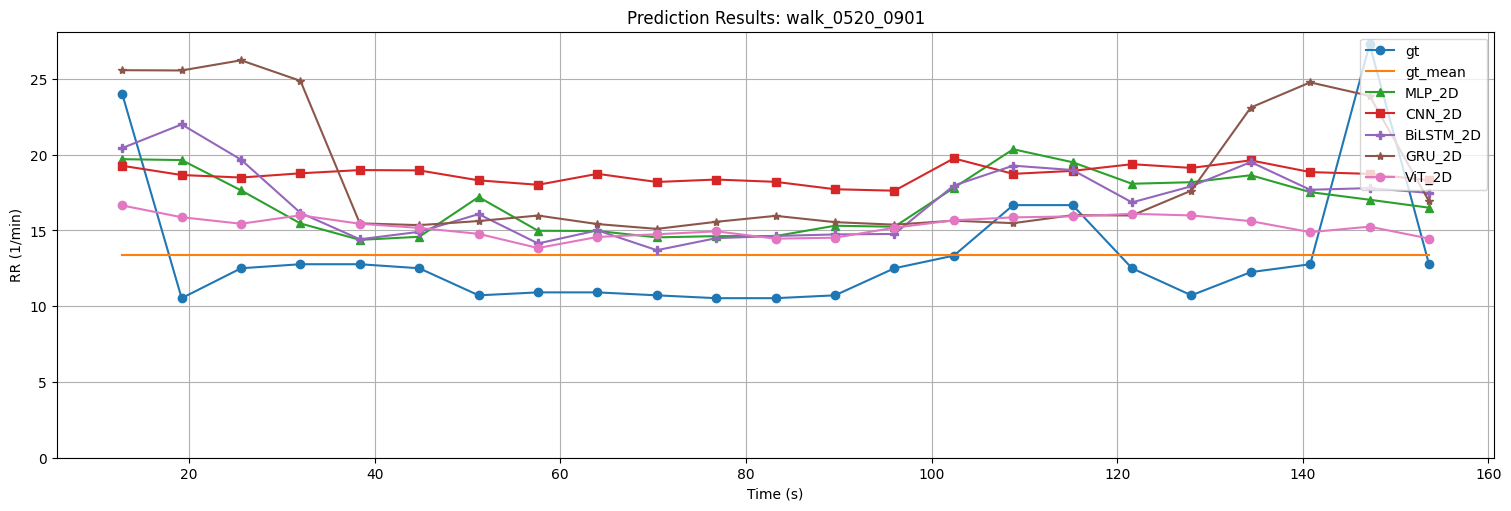

In [11]:
# avg_mse_loss, avg_l1_loss, preds = evaluate_models_file(models, file_loader, models_name=["MLP_1D", "CNN_1D"], gt=gts_file, times=times_file, action_name=action_name)
avg_mse_loss, avg_l1_loss, preds = evaluate_models_file(models, file_loader, models_name=["MLP_2D", "CNN_2D", "BiLSTM_2D", "GRU_2D", "ViT_2D"], gt=gts_file, times=times_file, action_name=action_name)

## Testing Actions

In [12]:
# Load dataset
dataset_dir = "dataset/action"
dataset_name = "8P_16_2D"
pkl_test = pickle.load(open(os.path.join(dataset_dir, f'{dataset_name}_test.pkl'), 'rb'))
input_test, gt_test = pkl_test['input'], pkl_test['gt']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

first_key = next(iter(input_test))
num_channels = input_test[first_key].shape[1]
num_freq_bins = input_test[first_key].shape[2]
num_time_steps = input_test[first_key].shape[3]

action_order = ['sit', 'stand', 'walk', 'run']
input_test = {k : input_test[k] for k in action_order}
gt_test = {k : gt_test[k] for k in action_order}
print('Testing data......')
for k, v in input_test.items():
    print(f'action: {k}')
    # print(f'input_test[{k}]:{input_test[k].shape}')
    # print(f'gt_test[{k}]:{gt_test[k].shape}')

Testing data......
action: sit
action: stand
action: walk
action: run


In [13]:
# 2-D spectrogram
models_name = ['MLP_8P_2D_BC', 'CNN_8P_2D_BC', 'BiLSTM_8P_2D_BC', 'GRU_8P_2D_BC', 'VT_8P_BC_emht2']
models = [MLP_out1(num_freq_bins, num_time_steps, num_channels=num_channels),
          CNN_out1_2(num_channels=num_channels),
          BiLSTM(num_freq_bins, num_time_steps, num_channels=num_channels),
          GRU(num_freq_bins, num_time_steps, num_channels=num_channels),
          VT.ViTRegression(in_channels=num_channels, patch_size=(3, 3), emb_dim=256, mlp_dim=512, num_heads=8, device=device)]

for i in range(len(models_name)):
    models[i].load_state_dict(torch.load(f'./models/{str(models_name[i])}.pt'))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MLP
sit - MSE Loss: 0.0005, L1 Loss: 1.1730 1/min
stand - MSE Loss: 0.0016, L1 Loss: 1.8963 1/min
walk - MSE Loss: 0.0099, L1 Loss: 5.3244 1/min
run - MSE Loss: 0.0057, L1 Loss: 3.6548 1/min

CNN
sit - MSE Loss: 0.0023, L1 Loss: 2.1999 1/min
stand - MSE Loss: 0.0026, L1 Loss: 2.5479 1/min
walk - MSE Loss: 0.0079, L1 Loss: 4.7925 1/min
run - MSE Loss: 0.0018, L1 Loss: 2.1408 1/min

BiLSTM
sit - MSE Loss: 0.0006, L1 Loss: 1.1147 1/min
stand - MSE Loss: 0.0015, L1 Loss: 1.7203 1/min
walk - MSE Loss: 0.0106, L1 Loss: 5.4673 1/min
run - MSE Loss: 0.0030, L1 Loss: 2.6178 1/min

GRU
sit - MSE Loss: 0.0005, L1 Loss: 0.9263 1/min
stand - MSE Loss: 0.0006, L1 Loss: 1.1594 1/min
walk - MSE Loss: 0.0182, L1 Loss: 6.5381 1/min
run - MSE Loss: 0.0084, L1 Loss: 4.3741 1/min

ViT
sit - MSE Loss: 0.0013, L1 Loss: 1.7958 1/min
stand - MSE Loss: 0.0023, L1 Loss: 2.3909 1/min
walk - MSE Loss: 0.0046, L1 Loss: 3.4538 1/min
run - MSE Loss: 0.0031, L1 Loss: 2.8183 1/min



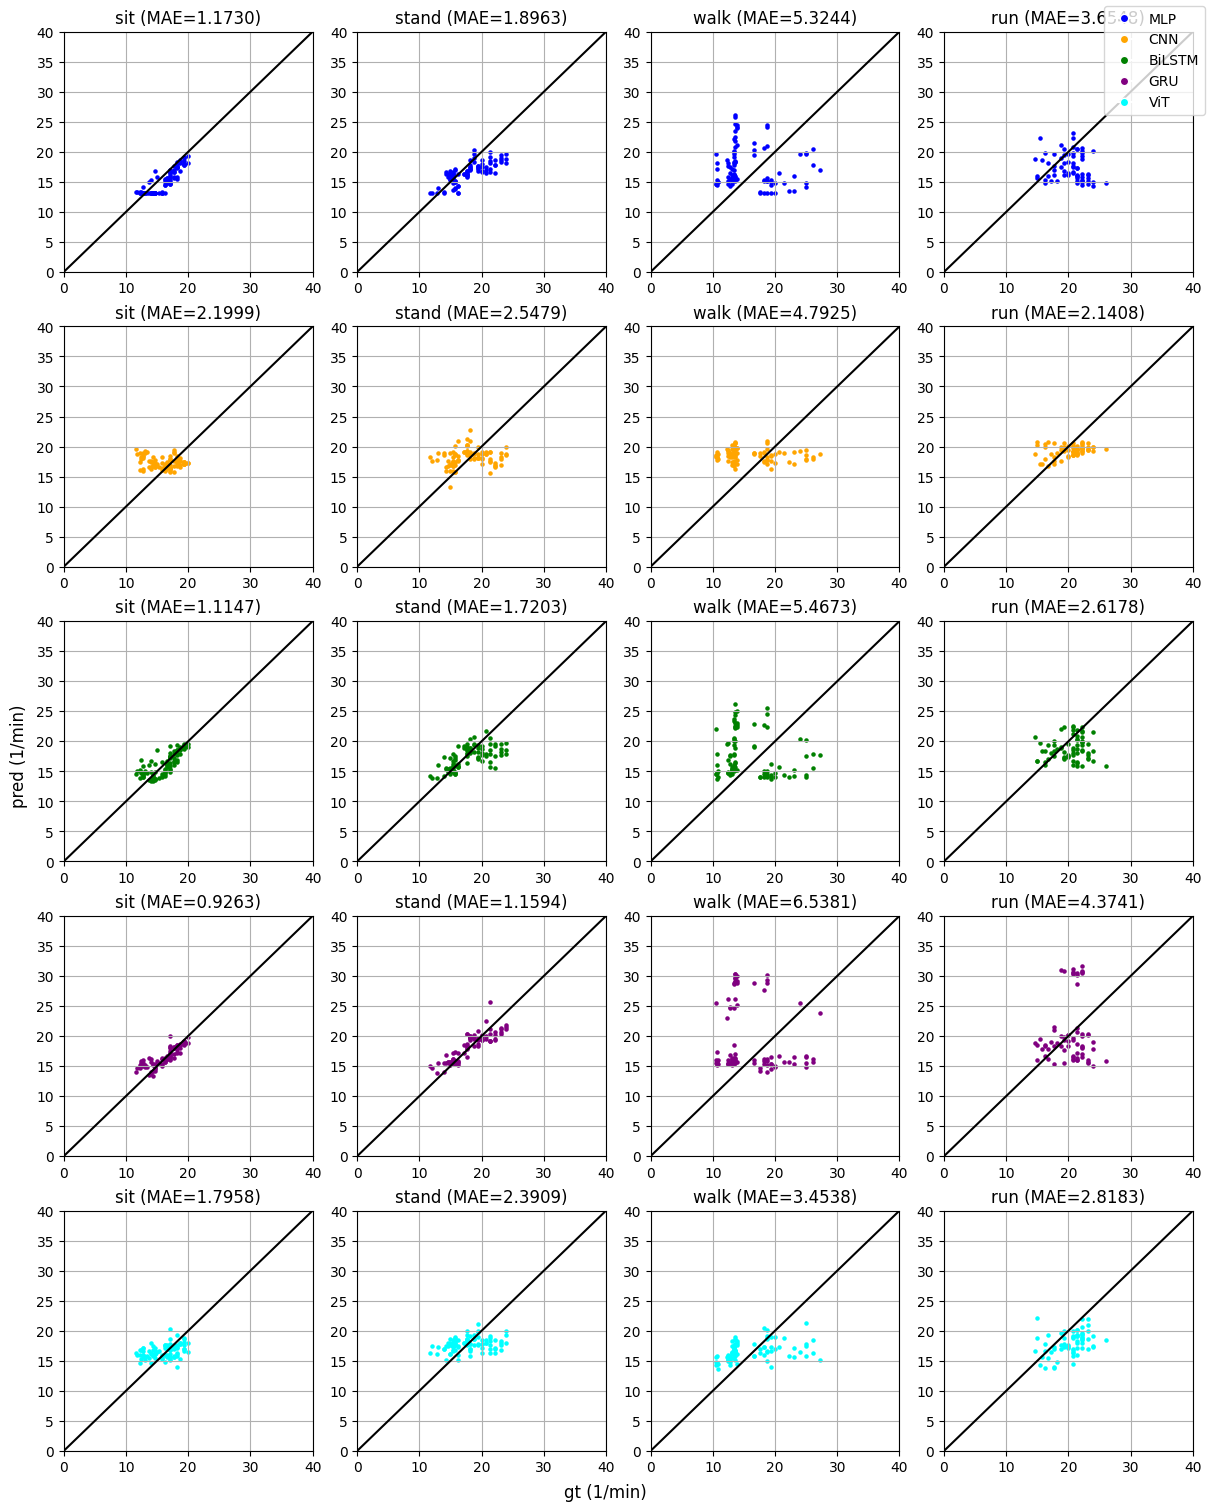

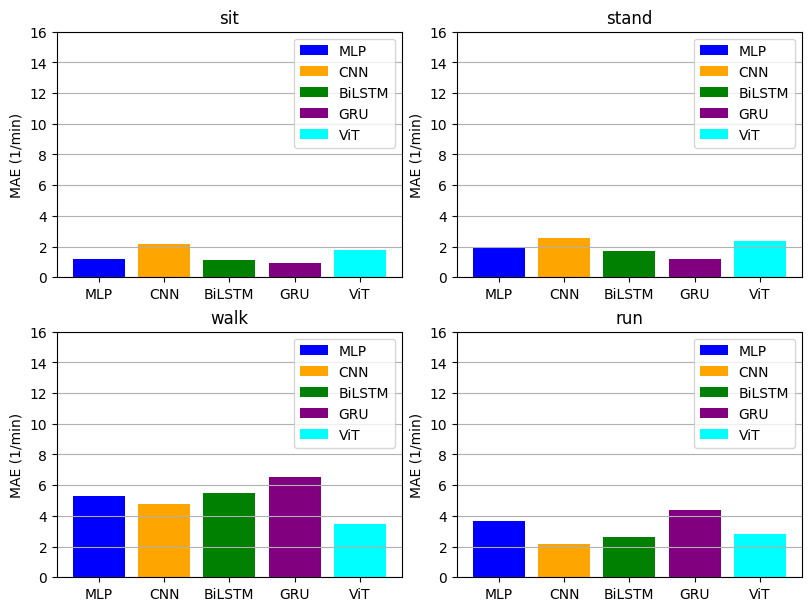

In [14]:
evaluate_models_action(models, input_test, gt_test, models_name=["MLP", "CNN", "BiLSTM", "GRU", "ViT"], device=device, visualize=True)

MLP
sit - MSE Loss: 0.0005, L1 Loss: 1.1730 1/min E%: 7.3724%
stand - MSE Loss: 0.0016, L1 Loss: 1.8963 1/min E%: 9.9921%
walk - MSE Loss: 0.0099, L1 Loss: 5.3244 1/min E%: 35.0797%
run - MSE Loss: 0.0057, L1 Loss: 3.6548 1/min E%: 17.3902%

CNN
sit - MSE Loss: 0.0023, L1 Loss: 2.1999 1/min E%: 15.4211%
stand - MSE Loss: 0.0026, L1 Loss: 2.5479 1/min E%: 14.5961%
walk - MSE Loss: 0.0079, L1 Loss: 4.7925 1/min E%: 33.9789%
run - MSE Loss: 0.0018, L1 Loss: 2.1408 1/min E%: 10.7005%

BiLSTM
sit - MSE Loss: 0.0006, L1 Loss: 1.1147 1/min E%: 7.6245%
stand - MSE Loss: 0.0015, L1 Loss: 1.7203 1/min E%: 9.1232%
walk - MSE Loss: 0.0106, L1 Loss: 5.4673 1/min E%: 35.8269%
run - MSE Loss: 0.0030, L1 Loss: 2.6178 1/min E%: 12.6834%

GRU
sit - MSE Loss: 0.0005, L1 Loss: 0.9263 1/min E%: 6.5105%
stand - MSE Loss: 0.0006, L1 Loss: 1.1594 1/min E%: 6.4580%
walk - MSE Loss: 0.0182, L1 Loss: 6.5381 1/min E%: 44.1787%
run - MSE Loss: 0.0084, L1 Loss: 4.3741 1/min E%: 21.0424%

ViT
sit - MSE Loss: 0.0013,

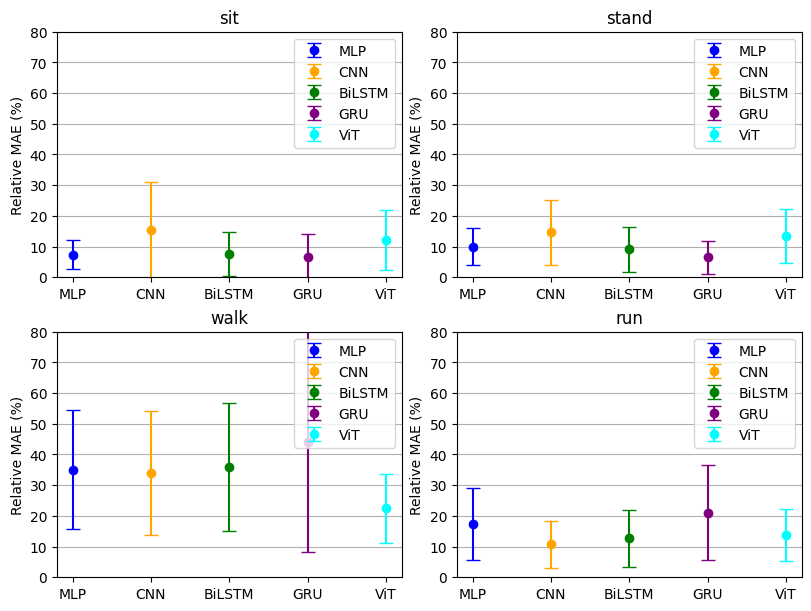

In [15]:
evaluate_models_action_relative(models, input_test, gt_test, models_name=["MLP", "CNN", "BiLSTM", "GRU", "ViT"], device=device, visualize=True)